In [1]:
import os

# Path to the dataset directory
data_dir = "colored_images"  # <- replace with your dataset path

# Dictionary to store counts
class_counts = {}

# Loop through each folder
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        num_images = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[folder] = num_images

# Print class-wise counts
print("Images per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

# Print total images
total_images = sum(class_counts.values())
print("\nTotal images in dataset:", total_images)


Images per class:
Mild: 370
Moderate: 999
No_DR: 1805
Proliferate_DR: 295
Severe: 193

Total images in dataset: 3662


In [2]:
import os
from PIL import Image

# Path to the dataset directory
data_dir = "colored_images"  # <- replace with your dataset path

# Dictionary to store corrupted and non-RGB images
corrupted_images = []
non_rgb_images = []

# Loop through folders and check images
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        for f in os.listdir(folder_path):
            file_path = os.path.join(folder_path, f)
            try:
                with Image.open(file_path) as img:
                    # Check if image is RGB
                    if img.mode != "RGB":
                        non_rgb_images.append(file_path)
            except Exception as e:
                # If the image cannot be opened, consider it corrupted
                corrupted_images.append(file_path)

# Print results
print("✅ Image Validation Complete!\n")

print(f"Total corrupted images: {len(corrupted_images)}")
if corrupted_images:
    print("Example corrupted file:", corrupted_images[0])

print(f"\nTotal non-RGB images: {len(non_rgb_images)}")
if non_rgb_images:
    print("Example non-RGB file:", non_rgb_images[0])

print("\nConfirmation: All remaining images are valid RGB and loadable! 🚀")


✅ Image Validation Complete!

Total corrupted images: 0

Total non-RGB images: 0

Confirmation: All remaining images are valid RGB and loadable! 🚀


In [4]:
pip install "numpy<2.0" --upgrade


Note: you may need to restart the kernel to use updated packages.


✅ Image Validation Complete!

Total corrupted images: 0
Total non-RGB images (auto-converted): 0

Unique image sizes: {(224, 224)}

Mean pixel values (R,G,B): [0.41350746 0.22069517 0.07336035]
Std pixel values  (R,G,B): [0.23874577 0.13181002 0.04927282]


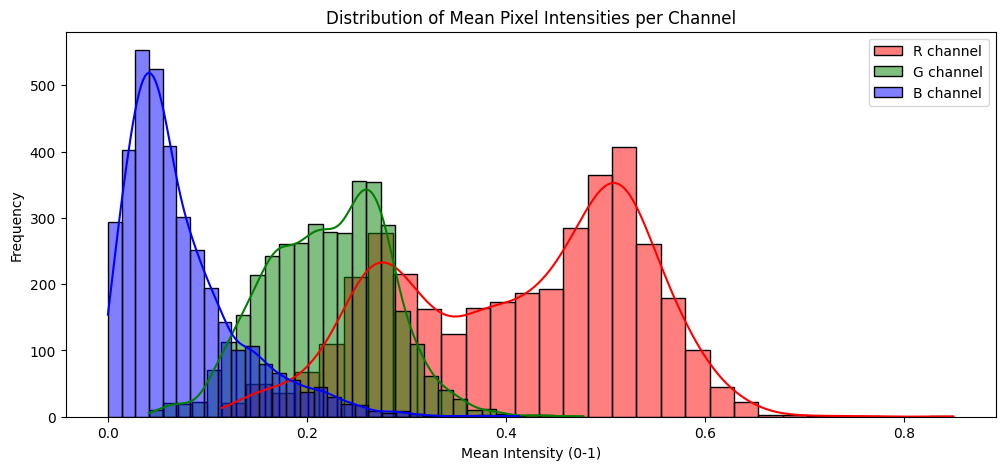

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# Path to dataset
data_dir = "colored_images"  # replace with your dataset path

# Storage
corrupted_images = []
non_rgb_images = []
shapes = []
pixel_means = []
pixel_stds = []

# Loop through dataset
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        for f in os.listdir(folder_path):
            file_path = os.path.join(folder_path, f)
            try:
                with Image.open(file_path) as img:
                    # Check RGB
                    if img.mode != "RGB":
                        non_rgb_images.append(file_path)
                        img = img.convert("RGB")  # convert for consistency
                    
                    # Record shape
                    shapes.append(img.size)  # (width, height)
                    
                    # Convert to numpy
                    arr = np.array(img) / 255.0  # normalize 0-1
                    pixel_means.append(arr.mean(axis=(0,1)))  # per channel mean
                    pixel_stds.append(arr.std(axis=(0,1)))    # per channel std
            except Exception:
                corrupted_images.append(file_path)

# Convert to numpy arrays
pixel_means = np.array(pixel_means)
pixel_stds = np.array(pixel_stds)

# ---- RESULTS ----
print("✅ Image Validation Complete!\n")
print(f"Total corrupted images: {len(corrupted_images)}")
print(f"Total non-RGB images (auto-converted): {len(non_rgb_images)}")

# Check unique image sizes
unique_shapes = set(shapes)
print(f"\nUnique image sizes: {unique_shapes}")

# Mean & std across dataset
mean_per_channel = pixel_means.mean(axis=0)
std_per_channel = pixel_stds.mean(axis=0)

print(f"\nMean pixel values (R,G,B): {mean_per_channel}")
print(f"Std pixel values  (R,G,B): {std_per_channel}")

# ---- PLOTS ----
# Histogram of pixel intensities
plt.figure(figsize=(12,5))
colors = ["r", "g", "b"]
for i, col in enumerate(colors):
    sns.histplot(pixel_means[:, i], color=col, kde=True, bins=30, label=f"{col.upper()} channel")
plt.legend()
plt.title("Distribution of Mean Pixel Intensities per Channel")
plt.xlabel("Mean Intensity (0-1)")
plt.ylabel("Frequency")
plt.show()


c:\Users\Sahil\anaconda3\envs\pytorch310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sahil\anaconda3\envs\pytorch310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


100%|██████████| 170M/170M [00:38<00:00, 4.40MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data


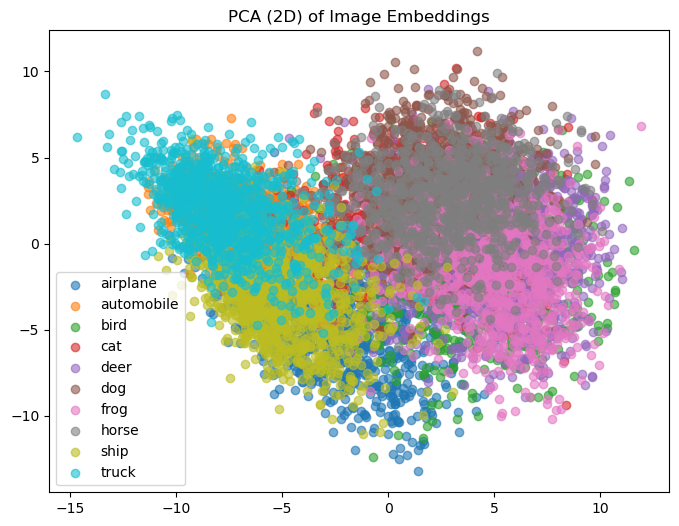

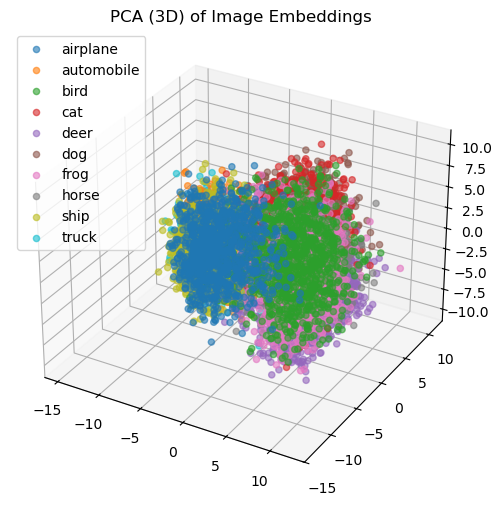

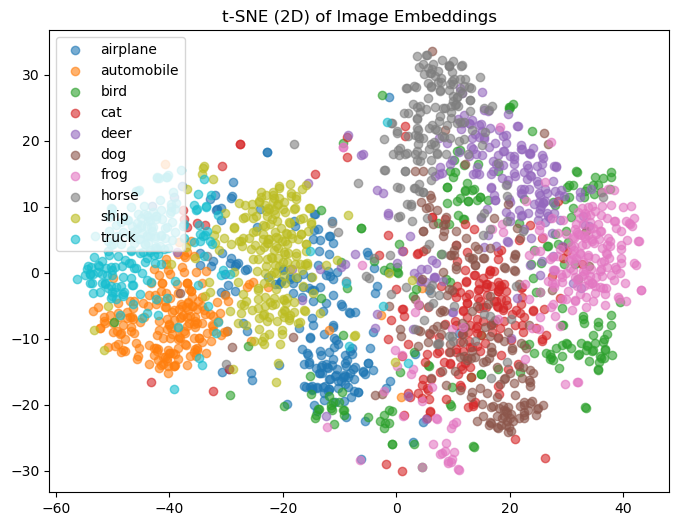

✅ Done! Plots saved in 'plots/' folder.


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import inspect
import os

# ---------------------------
# Device setup
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Load pretrained ResNet18
# ---------------------------
model = models.resnet18(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # remove classification head
model.to(device)
model.eval()

# ---------------------------
# Data transforms
# ---------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ---------------------------
# Load CIFAR-10 dataset
# ---------------------------
dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# ---------------------------
# Extract embeddings
# ---------------------------
embeddings = []
labels = []

with torch.no_grad():
    for images, target in dataloader:
        images = images.to(device)
        feats = model(images).squeeze()  # [batch_size, 512]
        embeddings.append(feats.cpu().numpy())
        labels.append(target.numpy())

embeddings = np.vstack(embeddings)
labels = np.hstack(labels)
class_names = dataset.classes

# ---------------------------
# Make output folder
# ---------------------------
os.makedirs("plots", exist_ok=True)

# ---------------------------
# PCA - 2D
# ---------------------------
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
for idx, name in enumerate(class_names):
    plt.scatter(pca_result[labels==idx,0], 
                pca_result[labels==idx,1], 
                label=name, alpha=0.6)
plt.legend()
plt.title("PCA (2D) of Image Embeddings")
plt.savefig("plots/pca_2d.png", dpi=300)
plt.show()

# ---------------------------
# PCA - 3D
# ---------------------------
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(embeddings)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for idx, name in enumerate(class_names):
    ax.scatter(pca_result_3d[labels==idx,0],
               pca_result_3d[labels==idx,1],
               pca_result_3d[labels==idx,2],
               label=name, alpha=0.6)
ax.legend()
ax.set_title("PCA (3D) of Image Embeddings")
plt.savefig("plots/pca_3d.png", dpi=300)
plt.show()

# ---------------------------
# t-SNE Visualization
# ---------------------------
# Check which parameter exists (n_iter or max_iter)
if "n_iter" in inspect.signature(TSNE).parameters:
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
else:
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)

# To save time, only use a subset (e.g., 2000 points)
tsne_result = tsne.fit_transform(embeddings[:2000])
tsne_labels = labels[:2000]

plt.figure(figsize=(8,6))
for idx, name in enumerate(class_names):
    plt.scatter(tsne_result[tsne_labels==idx,0], 
                tsne_result[tsne_labels==idx,1], 
                label=name, alpha=0.6)
plt.legend()
plt.title("t-SNE (2D) of Image Embeddings")
plt.savefig("plots/tsne_2d.png", dpi=300)
plt.show()

print("✅ Done! Plots saved in 'plots/' folder.")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.models import convnext_base
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# --- 1. Setup and Configuration ---
# Your main data directory
DATA_DIR = "./colored_images" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. Data Transformations and Loading ---
# Define the image transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # Add some data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Use ImageFolder to load the entire dataset
try:
    full_dataset = ImageFolder(root=DATA_DIR, transform=data_transform)
    print("Dataset loaded successfully!")
    print(f"Found {len(full_dataset)} images in {len(full_dataset.classes)} classes.")
    print("Classes:", full_dataset.class_to_idx)
except FileNotFoundError:
    print("="*50)
    print(f"ERROR: The directory '{DATA_DIR}' was not found.")
    print("Please ensure the path is correct.")
    print("="*50)
    exit() # Exit if the dataset path is wrong

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# --- 3. Model, Loss, and Optimizer ---
# Load the pre-trained ConvNeXt V1 model
model = convnext_base(pretrained=True)

# Get the number of classes from the dataset
num_classes = len(full_dataset.classes)
# Replace the final layer
model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)

# Move to device, define loss and optimizer
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# --- 4. Training and Validation Loop ---
print("\nStarting training for 5 epochs...")
for epoch in range(5):
    # Training phase
    model.train()
    running_train_loss, correct_train, total_train = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    train_loss = running_train_loss / total_train
    train_acc = correct_train / total_train
    
    # Validation phase
    model.eval()
    running_val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    val_loss = running_val_loss / total_val
    val_acc = correct_val / total_val
    
    print(f"\n--- Epoch {epoch+1}/5 ---")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

print("\nTraining finished.")

# --- 5. Grad-CAM Implementation ---

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output): self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out): self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def __call__(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)
        if class_idx is None: class_idx = torch.argmax(output).item()
        
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activations.shape[1]): self.activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(self.activations, dim=1).squeeze().cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        return heatmap

def show_grad_cam(image_path, heatmap):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap_colored * 0.4 + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    # Display side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title("Original Image")
    ax1.axis('off')
    
    ax2.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    ax2.set_title("Grad-CAM Overlay")
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

# --- 6. Generate and Display Grad-CAM ---
# Target the last block of the last stage in ConvNeXt's feature extractor
target_layer = model.features[-1][-1].block
grad_cam = GradCAM(model=model, target_layer=target_layer)

# Get a sample image from the validation set to visualize
sample_idx = 0
image_path = val_dataset.dataset.imgs[val_dataset.indices[sample_idx]][0]
sample_tensor, sample_label = val_dataset[sample_idx]
input_tensor = sample_tensor.unsqueeze(0).to(device)

# Generate and show heatmap
print(f"\nGenerating Grad-CAM for a sample validation image...")
heatmap = grad_cam(input_tensor)
show_grad_cam(image_path, heatmap)


Dataset loaded successfully!
Found 3662 images in 5 classes.
Classes: {'Mild': 0, 'Moderate': 1, 'No_DR': 2, 'Proliferate_DR': 3, 'Severe': 4}


c:\Users\Sahil\anaconda3\envs\pytorch310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sahil\anaconda3\envs\pytorch310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Starting training for 5 epochs...

--- Epoch 1/5 ---
Train Loss: 0.6982 | Train Acc: 0.7453
Val Loss:   0.5376 | Val Acc:   0.7913

--- Epoch 2/5 ---
Train Loss: 0.4623 | Train Acc: 0.8204
Val Loss:   0.5654 | Val Acc:   0.8035

--- Epoch 3/5 ---
Train Loss: 0.3879 | Train Acc: 0.8590
Val Loss:   0.5384 | Val Acc:   0.8186
